In [14]:
# !curl http://localhost:3000/export.php -o puppeteer.csv

=== XGBoost Classification Report (thresholded) ===
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       300
           1       0.98      0.99      0.99       300

    accuracy                           0.98       600
   macro avg       0.99      0.98      0.98       600
weighted avg       0.99      0.98      0.98       600


=== Random Forest Classification Report (thresholded) ===
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       300
           1       0.97      0.99      0.98       300

    accuracy                           0.98       600
   macro avg       0.98      0.98      0.98       600
weighted avg       0.98      0.98      0.98       600



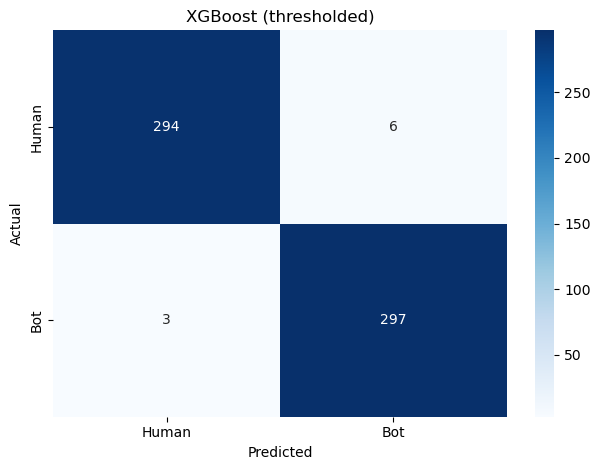

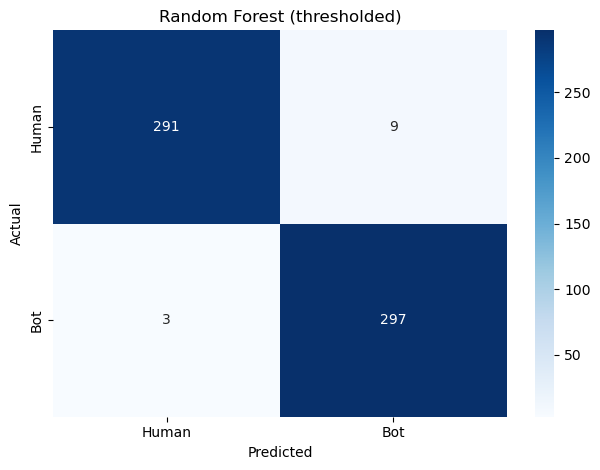


XGBoost kept 11 features:
 ['session_duration', 'avg_time_per_page', 'mouse_distance_avg', 'mouse_avg_speed', 'mouse_max_speed', 'mouse_sharp_turns', 'mouse_straight_movements', 'avg_scroll_depth', 'avg_scroll_speed', 'total_scrolls', 'total_clicks']

Random Forest kept 11 features:
 ['session_duration', 'avg_time_per_page', 'mouse_distance_avg', 'mouse_avg_speed', 'mouse_max_speed', 'mouse_sharp_turns', 'mouse_straight_movements', 'avg_scroll_depth', 'avg_scroll_speed', 'total_scrolls', 'total_clicks']


In [ ]:
import pandas as pd
import numpy as np
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

# --- Configurable thresholds for feature selection ---
XGB_FEATURE_THRESHOLD = 0.01   # keep features with importance ≥ 0.01 in XGBoost
RF_FEATURE_THRESHOLD  = 0.01   # keep features with importance ≥ 0.01 in Random Forest

# --- Load & label data ---
df_puppeteer = pd.read_csv("puppeteer.csv")
df_humans    = pd.read_csv("humans.csv")

df_puppeteer["label"] = 1
df_humans["label"]     = 0

df = pd.concat([df_puppeteer, df_humans], ignore_index=True)
df.to_csv("combined_sessions.csv", index=False)

# --- Drop poorly recorded columns & keep only numeric features ---
df = df.drop(columns=[
    "session_id", "mouse_idle_time", "avg_time_between_clicks"
], errors="ignore")
df = df.select_dtypes(include="number")

# --- Winsorize to cap top 1% outliers ---
winsor_cols = [
    "avg_time_per_page","total_scrolls","session_duration","avg_typing_speed",
    "total_clicks","avg_time_between_clicks","pages_visited","mouse_distance_avg",
    "mouse_sharp_turns","avg_scroll_depth","avg_scroll_speed","mouse_avg_speed",
    "mouse_straight_movements","mouse_max_speed","avg_shortcut_use"
]
for col in winsor_cols:
    if col in df.columns:
        df[col] = winsorize(df[col], limits=(0.0, 0.01))

# --- Split features & target ---
X = df.drop(columns="label")
y = df["label"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# compute class weight for imbalance
bot_weight = (y_train == 0).sum() / (y_train == 1).sum()

# --- 1) Train a baseline XGBoost to get importances ---
xgb_base = xgb.XGBClassifier(
    eval_metric="logloss",
    scale_pos_weight=bot_weight
)
xgb_base.fit(X_train, y_train)

# Select features above the XGB threshold (operate on NumPy arrays to avoid warnings)
sel_xgb = SelectFromModel(xgb_base, threshold=XGB_FEATURE_THRESHOLD, prefit=True)
X_tr_xgb = sel_xgb.transform(X_train.values)
X_vl_xgb = sel_xgb.transform(X_val.values)
cols_xgb = X_train.columns[sel_xgb.get_support()]

# Retrain on reduced feature set
xgb_sel = xgb.XGBClassifier(
    eval_metric="logloss",
    scale_pos_weight=bot_weight
)
xgb_sel.fit(X_tr_xgb, y_train)

y_pred_xgb = xgb_sel.predict(X_vl_xgb)
print("=== XGBoost Classification Report (thresholded) ===")
print(classification_report(y_val, y_pred_xgb))

# --- 2) Train a baseline Random Forest to get importances ---
rf_base = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight="balanced"
)
rf_base.fit(X_train, y_train)

# Select features above the RF threshold
sel_rf = SelectFromModel(rf_base, threshold=RF_FEATURE_THRESHOLD, prefit=True)
X_tr_rf = sel_rf.transform(X_train.values)
X_vl_rf = sel_rf.transform(X_val.values)
cols_rf = X_train.columns[sel_rf.get_support()]

# Retrain on reduced feature set
rf_sel = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight="balanced"
)
rf_sel.fit(X_tr_rf, y_train)

y_pred_rf = rf_sel.predict(X_vl_rf)
print("\n=== Random Forest Classification Report (thresholded) ===")
print(classification_report(y_val, y_pred_rf))

# --- 3) Confusion matrices ---
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Human","Bot"], yticklabels=["Human","Bot"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_conf_matrix(y_val, y_pred_xgb, "XGBoost (thresholded)")
plot_conf_matrix(y_val, y_pred_rf,  "Random Forest (thresholded)")

# --- 4) Which features survived thresholding? ---
print(f"\nXGBoost kept {len(cols_xgb)} features:\n", list(cols_xgb))
print(f"\nRandom Forest kept {len(cols_rf)} features:\n", list(cols_rf))

importances_xgb = xgb_sel.feature_importances_
feat_imp_xgb = pd.DataFrame({
    "feature": cols_xgb,
    "importance": importances_xgb
})
# sort ascending for barh (so highest appears at top)
feat_imp_xgb = feat_imp_xgb.sort_values("importance", ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp_xgb["feature"], feat_imp_xgb["importance"])
plt.xlabel("Importance")
plt.title("Feature Importance – XGBoost (thresholded)")
plt.tight_layout()
plt.show()

# 5b) Random Forest (thresholded) feature importances
importances_rf = rf_sel.feature_importances_
feat_imp_rf = pd.DataFrame({
    "feature": cols_rf,
    "importance": importances_rf
})
feat_imp_rf = feat_imp_rf.sort_values("importance", ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(feat_imp_rf["feature"], feat_imp_rf["importance"])
plt.xlabel("Importance")
plt.title("Feature Importance – Random Forest (thresholded)")
plt.tight_layout()
plt.show()